In [2]:
import numpy as np
import pandas as pd
from numpy.random import beta
from numpy.random import normal
from numpy.random import gamma
import matplotlib.pyplot as plt
import os
from scipy.stats import ks_2samp
from scipy.stats import wilcoxon

# Parameters recovery

## Difficulty/Discrimination and Ability

In [33]:
N = 500 # Respondents
M = 50 # Items

a_prior_mean = 1.0
a_prior_std = 1.0

ability = beta(a = 1.0, b = 1.0, size = N)
difficulty = beta(a = 1.0, b = 1.0, size = M)
discrimination = np.ones_like(difficulty)#normal(loc = a_prior_mean, scale = a_prior_std, size = M)
parameters = np.array([difficulty, discrimination]).T

## Estimating Alpha and Beta parameters

In [25]:
def Alpha_ij(theta_i, delta_j, a_j):
    div = delta_j/theta_i
    alpha = div ** (a_j)
    return alpha

def Beta_ij(theta_i, delta_j, a_j):
    num = (1 - delta_j)
    denom = (1 - theta_i)
    div = num/denom
    beta = div ** (a_j)
    return beta

Alpha = np.zeros((M, N))
Beta = np.zeros((M, N))
for i, params in enumerate(parameters):
    for j, theta in enumerate(ability):
        Alpha[i, j] = Alpha_ij(theta, params[0], params[1])
        Beta[i, j] = Beta_ij(theta, params[0], params[1])

## Estimating the errors from Gamma distribution

In [26]:
errors = np.clip(gamma(shape = Alpha, scale = 1/Beta), 1e-4, 100)

In [27]:
np.sum(errors == 100)

2669

## Inference to find new Parameters and Abilities

In [36]:
import sys
sys.path.append('./student-experiments/')

import tensorflow as tf
from edward.models import Normal,Beta
from models.gamma_irt import Gamma_IRT
   
niter = 1000

theta = Beta(tf.ones([N]),tf.ones([N]), sample_shape=[M], name='theta')
delta = Beta(tf.ones([M]),tf.ones([M]), sample_shape=[N], name='delta')
a = Normal(tf.ones(M) * a_prior_mean,tf.ones([M]) * a_prior_std,
    sample_shape=[N], name='a')

model = Gamma_IRT(M, N, theta, delta, 1.0, n_iter=niter)

D = np.float32(errors)

ab_rec, dif_rec, disc_rec = model.fit(D)

AttributeError: 'float' object has no attribute 'log_prob'

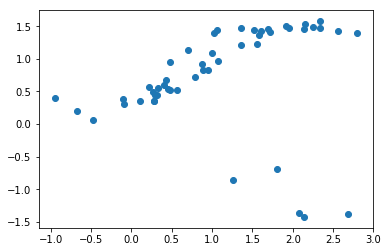

In [31]:
plt.scatter(discrimination, disc_rec.flatten())

In [32]:
print(wilcoxon(ability, ab_rec))
print(wilcoxon(difficulty, dif_rec))
print(wilcoxon(discrimination, disc_rec))

WilcoxonResult(statistic=9130.0, pvalue=1.601116998628897e-61)
WilcoxonResult(statistic=260.0, pvalue=0.0002683158388853629)
WilcoxonResult(statistic=521.0, pvalue=0.2607556207263785)
